In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
IMAGE_SIZE = [128,128]
train_data_dir = r'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Training'
test_data_dir = r'C:\Users\G VENKATA RAMANA\Downloads\archive (2)\Testing'

#train data preprocessing
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
traindata = pd.concat([Fseries, Lseries], axis= 1)
traindata

,filepaths,labels
0,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
1,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
2,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
3,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
4,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
...,...,...
5707,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5708,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5709,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
5710,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary


In [3]:
#test data preprocessing
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
testdata = pd.concat([Fseries,Lseries],axis='columns')
testdata

,filepaths,labels
0,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
1,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
2,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
3,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
4,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,glioma
...,...,...
1306,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1307,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1308,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary
1309,C:\Users\G VENKATA RAMANA\Downloads\archive (2...,pituitary


In [4]:
#Splitting the testdata to validation and test data
valid_df,test_df = train_test_split(testdata,train_size=0.75,shuffle=True,random_state=123)

In [5]:
#data augmentation
batch_size=32
channels = 3 
img_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],channels)  #128*128*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(traindata, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels',
                                       target_size= IMAGE_SIZE, 
                                       class_mode= 'categorical', 
                                       color_mode= 'rgb', 
                                       shuffle= True,
                                       batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels',
                                      target_size= IMAGE_SIZE, 
                                       class_mode= 'categorical', 
                                      color_mode= 'rgb', 
                                      shuffle= False ,
                                      batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe(valid_df,
                                        x_col= 'filepaths',
                                        y_col= 'labels',
                                        target_size= IMAGE_SIZE,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 983 validated image filenames belonging to 4 classes.


In [6]:
#_______________________________Implementing transfer learning_______________________________

IMAGE_SIZE = (128, 128)
channels = 3
img_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# Freeze all layers except the last 10 for fine-tuning
for layer in base_model.layers[:-10]:
  layer.trainable = False
  
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016),
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006),
          activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,592,068 (9.89 MB)

 Trainable params: 1,062,084 (4.05 MB)

 Non-trainable params: 1,529,984 (5.84 MB)

In [7]:
#_______________________________Training the model_______________________________

history = model.fit(x= train_gen, 
                    epochs= 20, 
                    verbose= 1, 
                    validation_data= valid_gen, 
                    shuffle= False)

warnings.filterwarnings("ignore")

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.6344 - loss: 17.2797 - val_accuracy: 0.3998 - val_loss: 12.4211
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 700ms/step - accuracy: 0.4375 - loss: 6.2340 - val_accuracy: 0.5860 - val_loss: 7.2768
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 646ms/step - accuracy: 0.3799 - loss: 5.0799 - val_accuracy: 0.6236 - val_loss: 5.0001
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 667ms/step - accuracy: 0.4475 - loss: 4.0548 - val_accuracy: 0.6317 - val_loss: 3.6782
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 668ms/step - accuracy: 0.4481 - loss: 3.1955 - val_accuracy: 0.5941 - val_loss: 2.7375
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.4761 - loss: 2.4941 - val_accuracy: 0.6562 - val_loss: 2.1124
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 794ms/step - accuracy: 0.4850 - loss: 2.0149 - val_accuracy: 0.6734 - val_loss: 1.7028
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.4891 - 

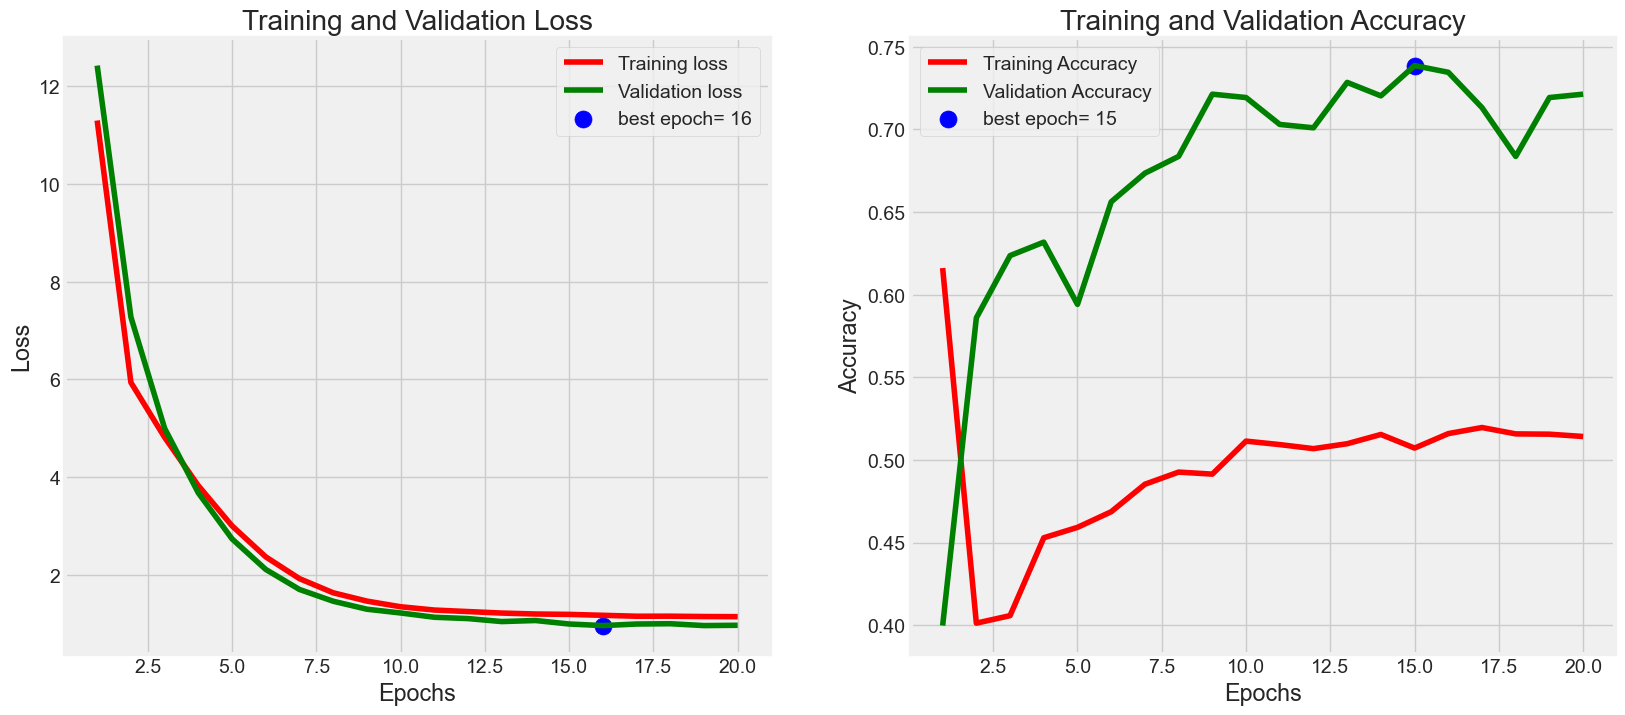

In [8]:
#_______________________________Model Evaluating_______________________________

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [9]:
#confusion matrix
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)


preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 


import itertools
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

179/179 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.7418 - loss: 0.9621
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7127 - loss: 0.9774
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7132 - loss: 0.9750


AttributeError: 'Sequential' object has no attribute 'predict_generator'

179/179 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.7391 - loss: 0.9691
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 852ms/step - accuracy: 0.7160 - loss: 0.9802
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 860ms/step - accuracy: 0.7132 - loss: 0.9750
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step


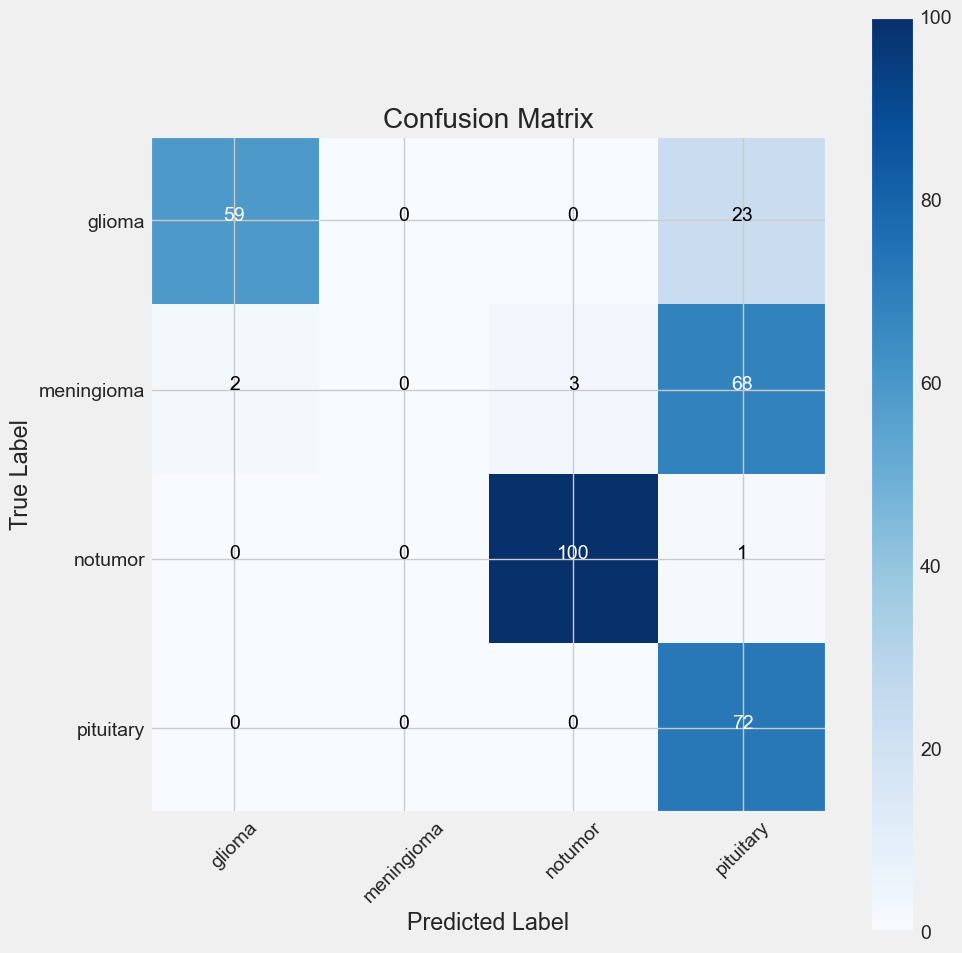

In [10]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

# Use 'predict' instead of 'predict_generator'
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices  # No change here

# Confusion Matrix
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot Confusion Matrix
import itertools
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', 
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [11]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_gen.classes, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.72      0.83        82
  meningioma       0.00      0.00      0.00        73
     notumor       0.97      0.99      0.98       101
   pituitary       0.44      1.00      0.61        72

    accuracy                           0.70       328
   macro avg       0.59      0.68      0.60       328
weighted avg       0.64      0.70      0.64       328

